Group Members: Dhruv Baid, Prajakta Phadke, Uday Sharma

In [1]:
# !pip install yahoofinance
# !pip install hmmlearn
# !pip install seaborn
# !pip install pandas==1.5.1
# !pip install numpy==1.21.4
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install gensim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn import preprocessing

from modules.cross_validation import Pipeline, CustomCrossValidation
from modules.data import *
from modules.directional_change import *
from modules.hidden_markov_model import make_regime_plots
from modules.kmeans import *
from modules.logistic_regression import do_all_LR
from modules.MixtureModels import *
from modules.NaiveBayesClassifier import *
from modules.svm import do_all_SVM
from modules.text_preprocessing import *
from modules.timeseries import *
from modules.trading_strategy import *
from modules.visualization import *

plt.style.use('seaborn')
sns.set_theme()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

In [4]:
FOMC_FPATH = '../fomc_documents/fomc_documents.csv'

In [5]:
fomc_data = get_text_data(fpath=FOMC_FPATH)
fomc_data

,document_kind,meeting_date,release_date,text,url
2947,minutes_of_actions,1985-02-13,1985-03-15,Meeting of the Federal Open Market Committee F...,https://www.federalreserve.gov/monetarypolicy/...
2960,minutes_of_actions,1985-03-26,1985-04-25,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2968,minutes_of_actions,1985-05-21,1985-06-20,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2982,minutes_of_actions,1985-07-10,1985-08-09,Meeting of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
2992,minutes_of_actions,1985-08-20,1985-09-19,Meeting of the Federal Open Market Committee A...,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...,...
5933,minutes,2022-12-14,2023-01-04,Minutes of the Federal Open Market Committee D...,https://www.federalreserve.gov/monetarypolicy/...
5936,minutes,2023-02-01,2023-02-22,Minutes of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
5940,minutes,2023-03-22,2023-04-12,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
5946,minutes,2023-05-03,2023-05-24,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...


In [6]:
# Remove names
fomc_data.text = fomc_data.text.apply(remove_names_from_minutes)

# Remove stop-words
fomc_data.text = fomc_data.text.apply(tokenizer_wo_stopwords)

fomc_data

,document_kind,meeting_date,release_date,text,url
2947,minutes_of_actions,1985-02-13,1985-03-15,vote gerald corrigan elected serve vice chairm...,https://www.federalreserve.gov/monetarypolicy/...
2960,minutes_of_actions,1985-03-26,1985-04-25,vote following officers open market elected se...,https://www.federalreserve.gov/monetarypolicy/...
2968,minutes_of_actions,1985-05-21,1985-06-20,vote actions taken open market held march appr...,https://www.federalreserve.gov/monetarypolicy/...
2982,minutes_of_actions,1985-07-10,1985-08-09,vote actions taken open market held approved,https://www.federalreserve.gov/monetarypolicy/...
2992,minutes_of_actions,1985-08-20,1985-09-19,vote actions taken open market held july approved,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...,...
5933,minutes,2022-12-14,2023-01-04,vote selected richard ostrander serve deputy g...,https://www.federalreserve.gov/monetarypolicy/...
5936,minutes,2023-02-01,2023-02-22,vote following officers selected serve selecti...,https://www.federalreserve.gov/monetarypolicy/...
5940,minutes,2023-03-22,2023-04-12,turned review financial market developments in...,https://www.federalreserve.gov/monetarypolicy/...
5946,minutes,2023-05-03,2023-05-24,turned review developments financial markets a...,https://www.federalreserve.gov/monetarypolicy/...


In [7]:
# Define train and test data
train_data = fomc_data[fomc_data.meeting_date <= datetime(2019, 12, 31)]
test_data = fomc_data[fomc_data.meeting_date > datetime(2019, 12, 31)]

In [8]:
# Compute TF-IDF values
tfidf_class = TF_IDF(X_train=train_data.text, X_test=test_data.text)

tfidf_class.fit_manual()
tfidf_class.fit_gensim()

In [9]:
# Train KMeans Clustering
model_kmeans = KMeansCluster(
    k=2,
    X_train=preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    X_test=preprocessing.normalize(tfidf_class.tfidf_gensim_test),
)
model_kmeans.fit()
model_kmeans.predict()

In [10]:
display(model_kmeans.sizes_train_df)
display(model_kmeans.sizes_test_df)

,CLUSTER_SIZE
CLUSTER,
0,57
1,224


,CLUSTER_SIZE
CLUSTER,
0,0
1,28


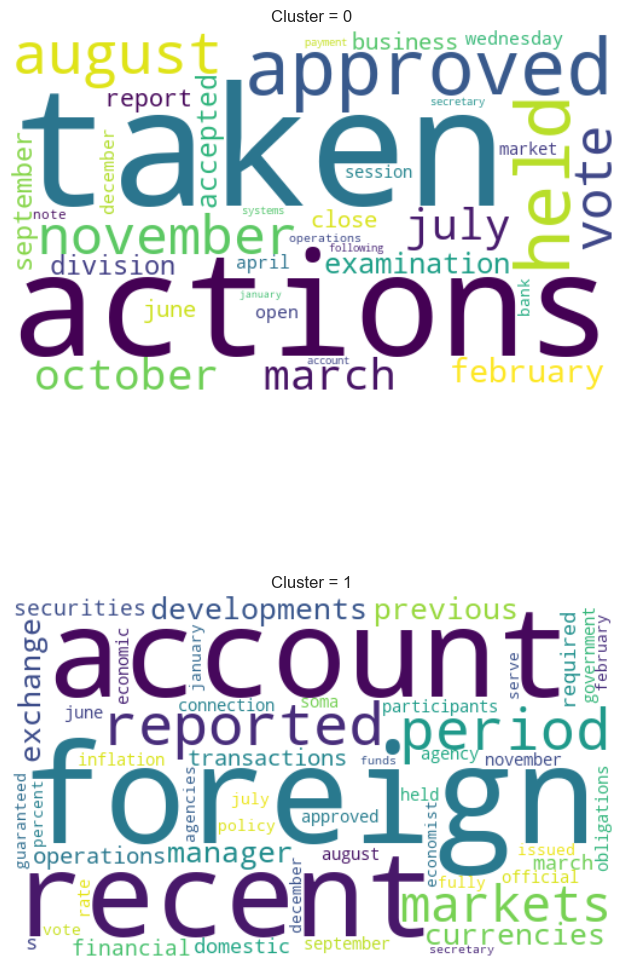

In [11]:
wordcloud_clusters(
    model_kmeans.model,
    preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    tfidf_class.dict_gensim_statements,
)

## Using FinBERT

In [19]:
fomc_data = get_text_data(fpath=FOMC_FPATH)
fomc_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,document_kind,meeting_date,release_date,text,url
2947,minutes_of_actions,1985-02-13,1985-03-15,Meeting of the Federal Open Market Committee F...,https://www.federalreserve.gov/monetarypolicy/...
2960,minutes_of_actions,1985-03-26,1985-04-25,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2968,minutes_of_actions,1985-05-21,1985-06-20,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2982,minutes_of_actions,1985-07-10,1985-08-09,Meeting of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
2992,minutes_of_actions,1985-08-20,1985-09-19,Meeting of the Federal Open Market Committee A...,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...,...
5933,minutes,2022-12-14,2023-01-04,Minutes of the Federal Open Market Committee D...,https://www.federalreserve.gov/monetarypolicy/...
5936,minutes,2023-02-01,2023-02-22,Minutes of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
5940,minutes,2023-03-22,2023-04-12,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
5946,minutes,2023-05-03,2023-05-24,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...


In [20]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained(
    'yiyanghkust/finbert-tone',
    num_labels=2
)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

labels = {
    0: 'normal',
    1: 'abnormal',
}

sent_val = list()
for x in fomc_data.text:
    inputs = tokenizer(x, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]
   
    val = labels[np.argmax(outputs.detach().numpy())]
    print(x, '----', val)
    print('#######################################################')    
    sent_val.append(val)

print(sent_val)

Neither PyTorch nor TensorFlow >= 2.0 have been found.Models won't be available and only tokenizers, configurationand file/data utilities can be used.


ImportError: cannot import name 'BertForSequenceClassification' from 'transformers' (C:\Users\dhruv\anaconda3\Lib\site-packages\transformers\__init__.py)

# Pipeline With Cross-Validation

In [19]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8]
}

In [20]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':12}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.1305995614876654, 'profit': 0.11294466215834031, 'sharpe': 0.45221807530971014}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.13110416467530533, 'profit': 0.09080363474279118, 'sharpe': 0.30836236577557885}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.14305879638395586, 'profit': 0.08665954285897826, 'sharpe': 0.2944372978219167}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'theta': 0.01}
Iteration: 4 of 45: Training complete.
Iteration: 4 of 45: Loss: {'drawdown': 0.095926414383

In [21]:
""" Optimal parameters and optimal value of the loss function. """

cv.get_optimal_loss()

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405,
 'parameters': {'DC_indicator': 'R', 'epsilon': 0.8, 'theta': 0.01}}

In [22]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


In [23]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405}

In [24]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


In [25]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.10658049858278516,
 'profit': 0.13305612063278272,
 'sharpe': 0.3877989114498797}

In [26]:
""" If you want to look at all the grid search results. """
# sorted(cv.get_losses(), key=lambda d: d['profit'])

' If you want to look at all the grid search results. '

In [27]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.1543405840247128,
 'profit': 0.37101175204318526,
 'sharpe': 0.47998209967808686}

In [28]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.15456424726434365,
 'profit': 0.3541043469635792,
 'sharpe': 0.5213167068175325}

In [29]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

In [30]:
""" If you want to get the results in Latex """
# print(cv.get_results_in_latex('Naive Bayes Cross-Validation Results'))

' If you want to get the results in Latex '

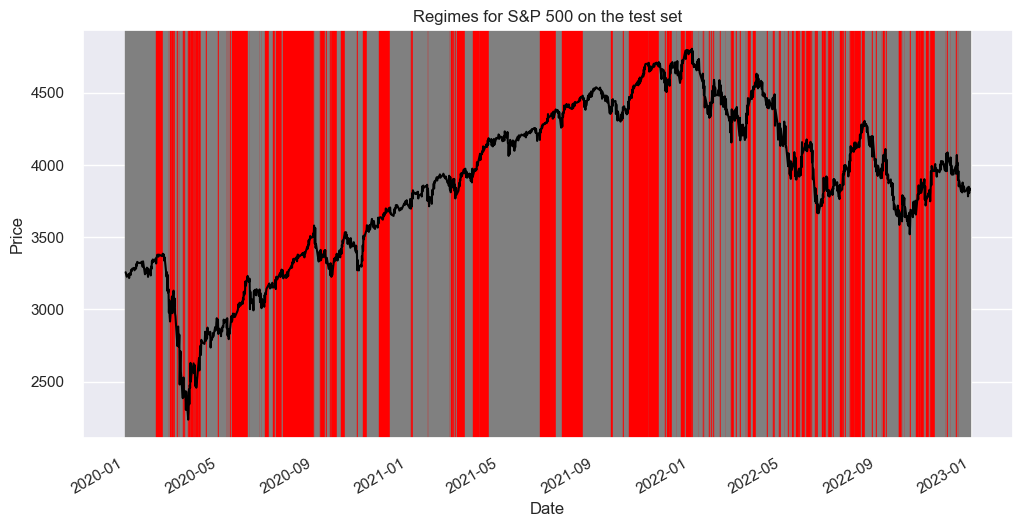

In [31]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the test set")
ax.set_ylabel("Price")
plt.show()

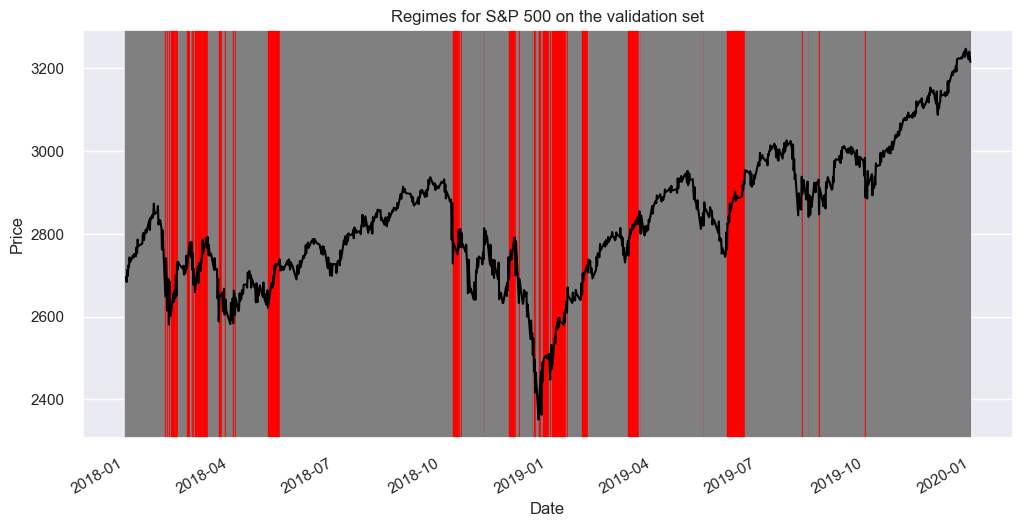

In [32]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the validation set")
ax.set_ylabel("Price")
plt.show()

## Visualizing DC indicators

In [33]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

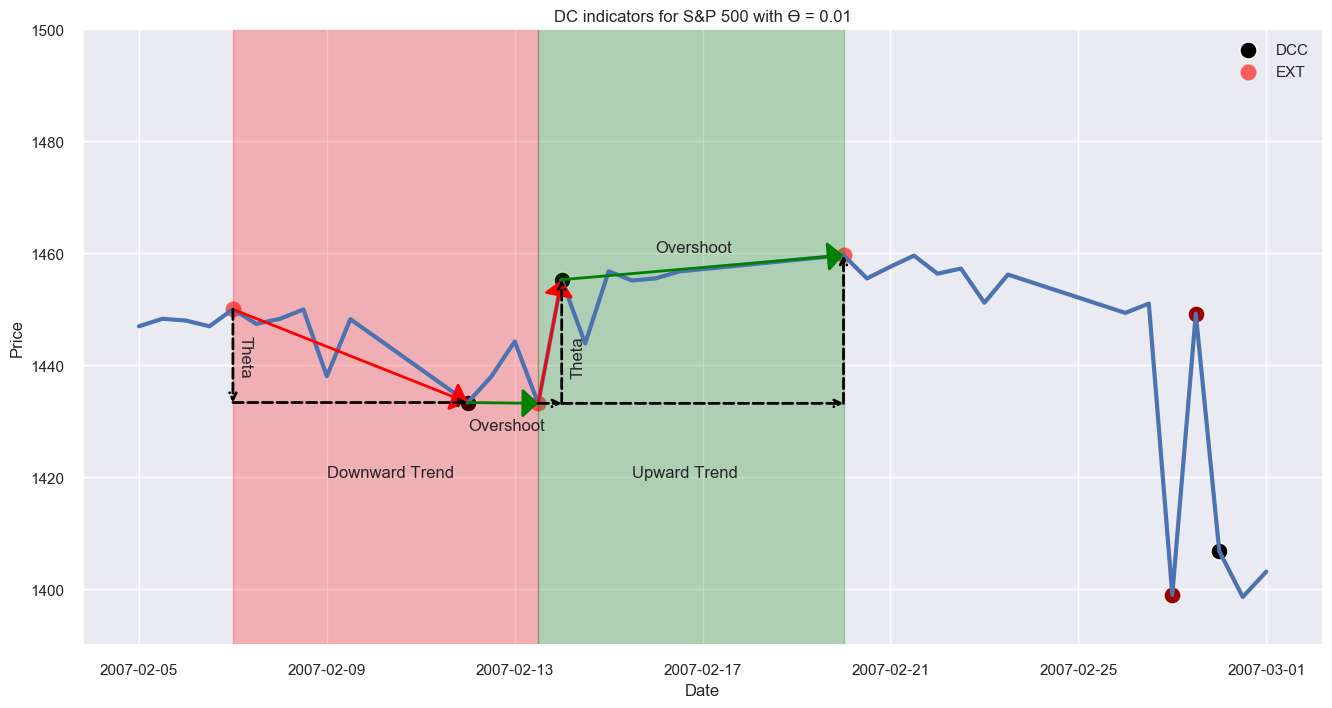

In [34]:
# example
sample_ts = df_ts[1050:1085]
first_date = sample_ts.index[0]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(model.dc['train'])):
    dcc.append(model.dc['train'][i][1])
    dcc_idx.append(model.dc['train'][i][0])
    ext.append( model.dc['train'][i][3] )
    ext_idx.append( model.dc['train'][i][2] )

dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[first_date:last_date]#.index
sample_ext = ext.loc[first_date:last_date]#.index

fig,ax = plt.subplots(figsize=(16,8))
features = model.dc['train']
sns.lineplot(data=sample_ts, linewidth=3)
sns.scatterplot(x = sample_dcc.index, y = sample_dcc, color='black', s=150, label='DCC',alpha=1, ax=ax)
sns.scatterplot(x = sample_ext.index, y = sample_ext, color='red', s=150, label='EXT',alpha=0.6, ax=ax)

annotate_plot(ax, sample_ext, sample_dcc)

ax.set_title(f"DC indicators for S&P 500 with ϴ = {model.theta}")
ax.set_ylabel("Price")
ax.set_ylim([1390, 1500])
ax.legend()
plt.show()

## Regime Characteristic Plots

In [35]:
model = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
model.fit()
regimes_test = strat_test.regimes_test
regimes_valid = strat_test.regimes_valid

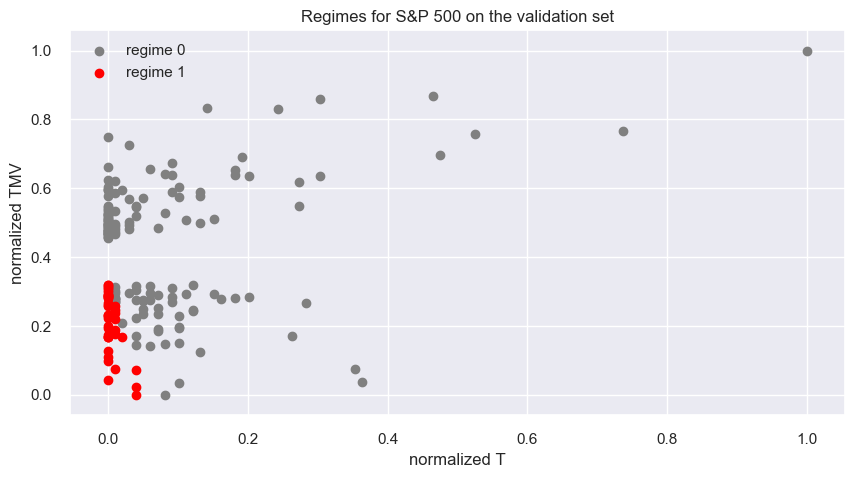

In [36]:
make_regime_plots(regimes_valid, model.tmv['valid'], model.T['valid'], 'S&P 500', 'validation')

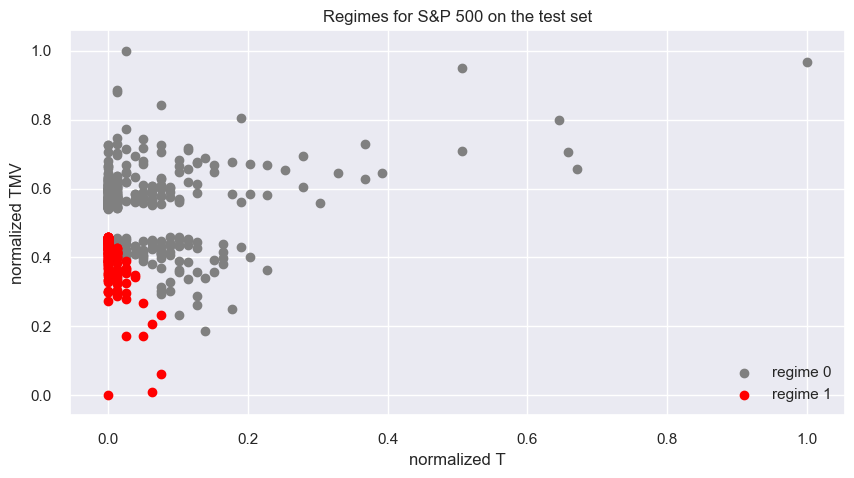

In [37]:
make_regime_plots(regimes_test, model.tmv['test'], model.T['test'], 'S&P 500', 'test')

## Comparing to Logistic Regression

In [38]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['logistic_regression']
}

In [39]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv2 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv2.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'l

In [40]:
""" Optimal parameters and optimal value of the loss function. """

cv2.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'logistic_regression',
  'theta': 0.019999999999999997}}

In [41]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv2.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [42]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [43]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv2.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [44]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [45]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [46]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [47]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [48]:
""" If you want to get the results in Latex """
# print(cv2.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='Logistic Regression Cross-Validation Results'))

' If you want to get the results in Latex '

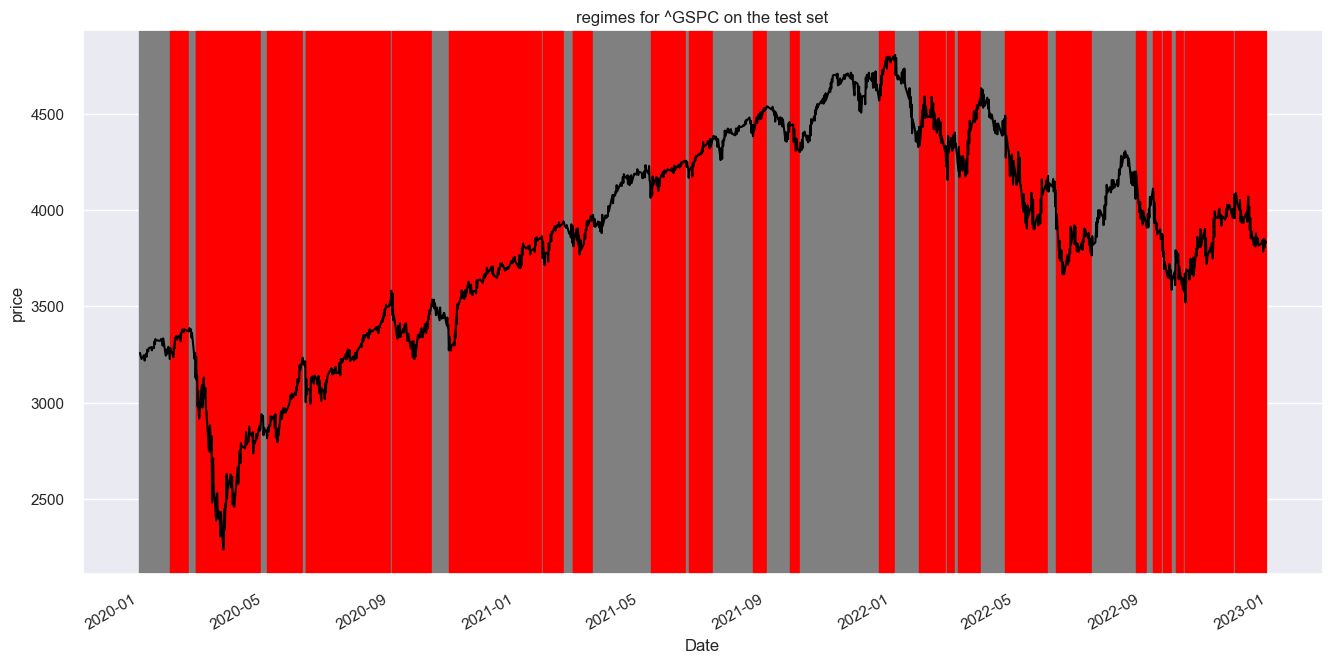

In [49]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

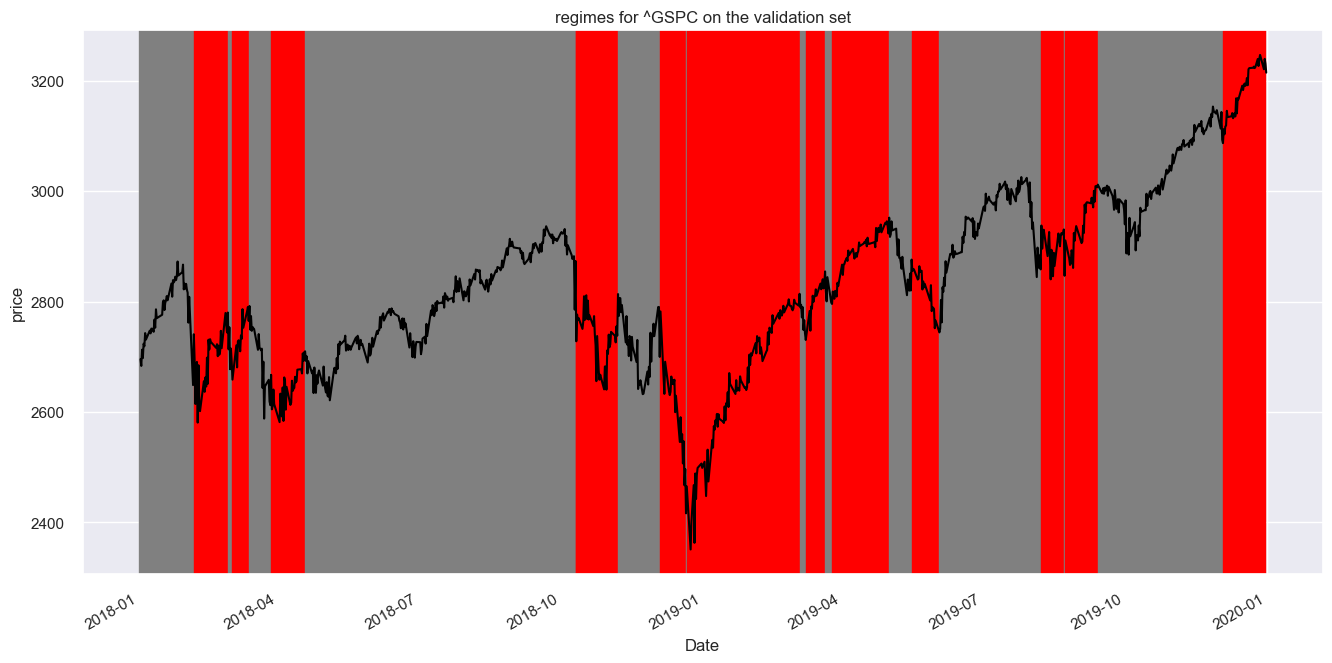

In [50]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

# Comparing to SVM

In [51]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['svm']
}

In [52]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv3 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv3.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'svm', 'theta': 0.01}
Iteration: 4 of 45: Training

In [53]:
""" Optimal parameters and optimal value of the loss function. """

cv3.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'svm',
  'theta': 0.019999999999999997}}

In [54]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv3.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [55]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [56]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv3.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [57]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [58]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [59]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [60]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [61]:
""" If you want to get the results in Latex """
# print(cv3.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='SVM Cross-Validation Results'))

' If you want to get the results in Latex '

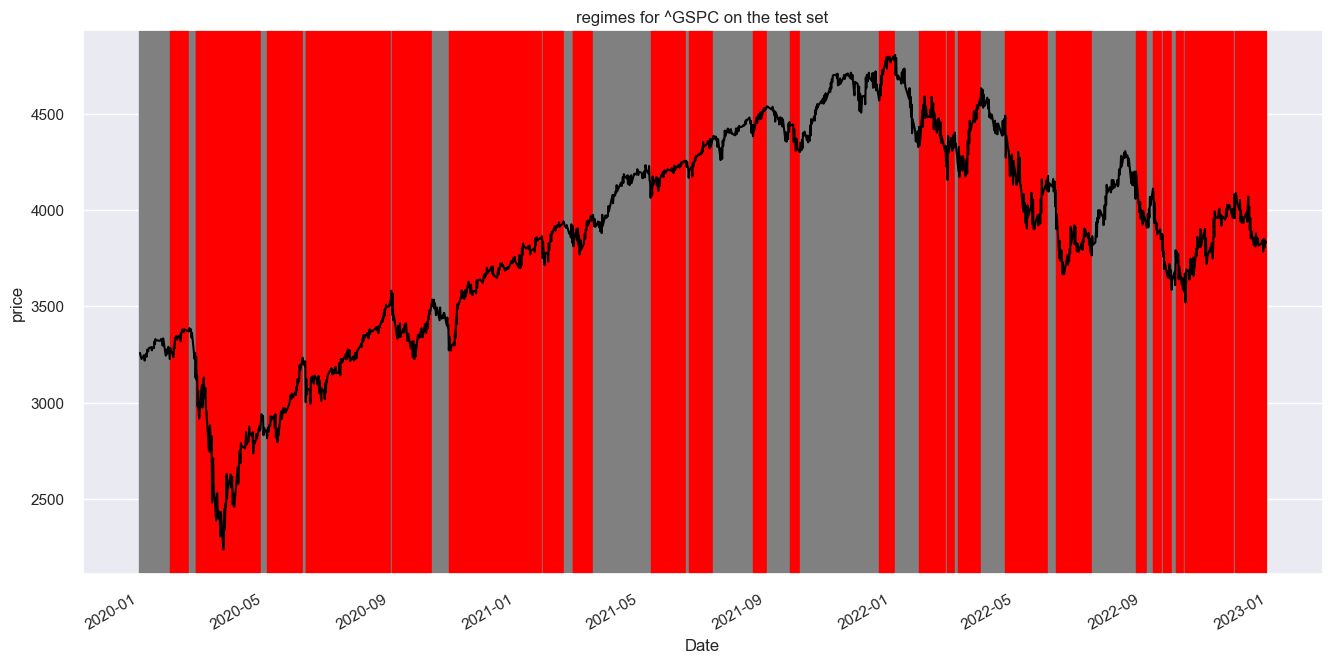

In [62]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

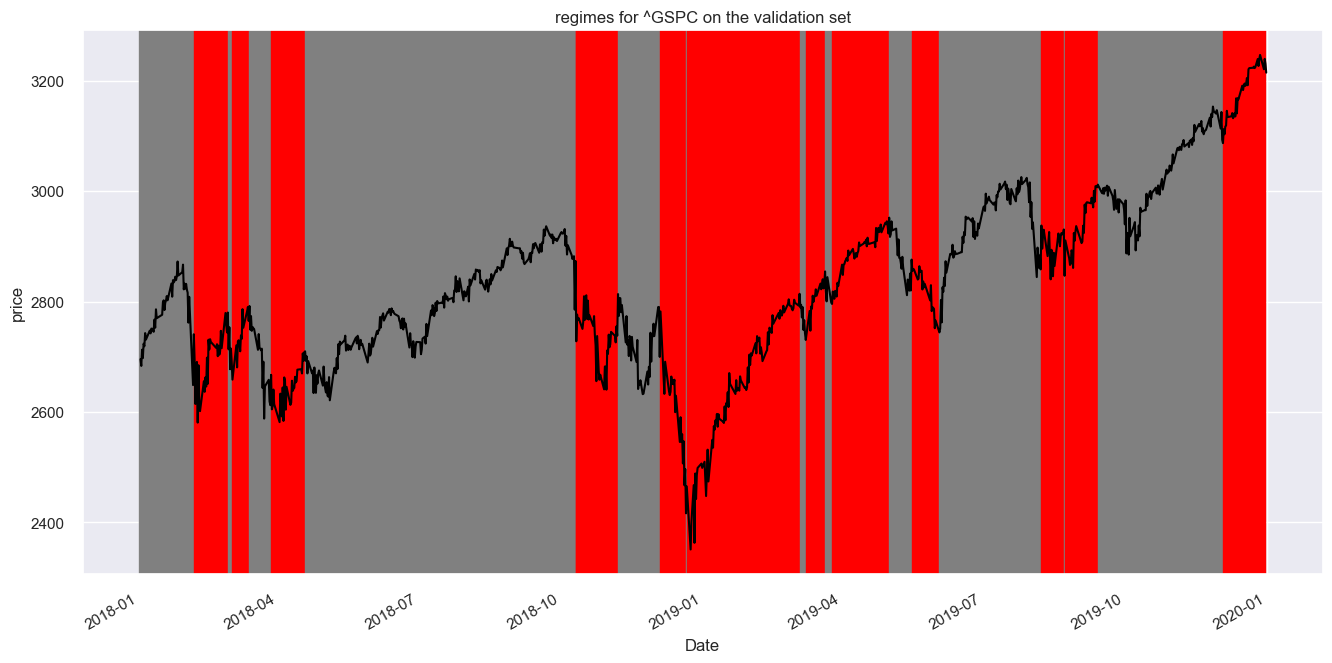

In [63]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

## Distribution of DCC indicator

In [64]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

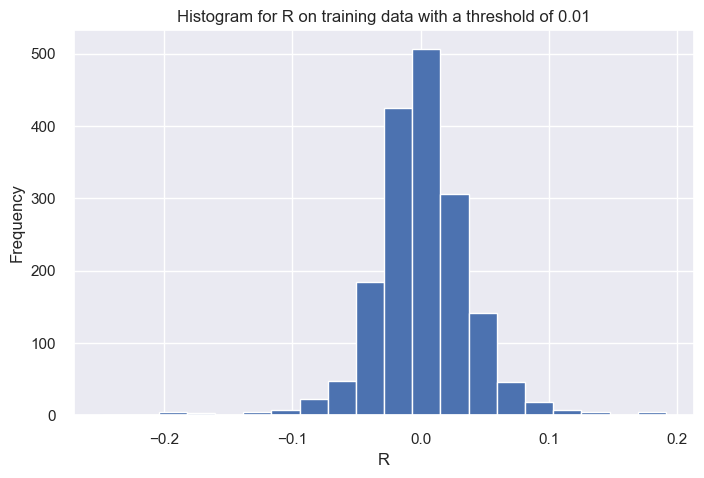

In [65]:
fig,ax = plt.subplots(figsize=(8,5))
model.R['train'].plot.hist(bins=20,ax=ax)
ax.set_title(f"Histogram for R on training data with a threshold of {cv.get_optimal_parameters()['theta']}")
ax.set_xlabel("R")
plt.show()

## Further analysis of SVM and Logistic Regression

In [66]:
""" Logistic Regression """
lr = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
lr.fit(verbose = True)
lr.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

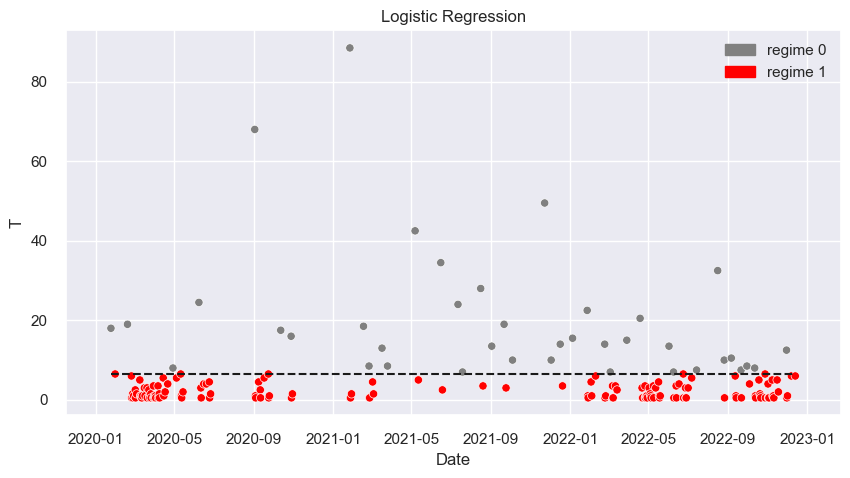

In [67]:
""" Checking linear separability for Logistic Regression on Test """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=lr.T['test'], c=np.where(lr.regimes_test==1, 'red','gray'))
plt.hlines(np.max(lr.T['test'][lr.regimes_test==1]),xmin=lr.T['test'].index[0],xmax=lr.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('Logistic Regression')
None

In [68]:
""" SVM """
sv = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
sv.fit(verbose = True)
sv.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

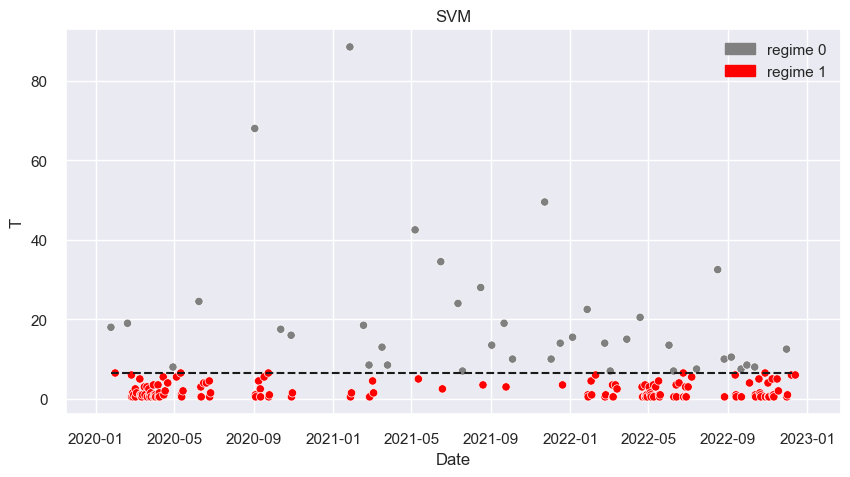

In [69]:
""" Checking linear separability for SVM Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=sv.T['test'], c=np.where(sv.regimes_test==1, 'red','gray'))
plt.hlines(np.max(sv.T['test'][sv.regimes_test==1]),xmin=sv.T['test'].index[0],xmax=sv.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('SVM')
None

In [70]:
""" naive Bayes """
nb = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
nb.fit(verbose = True)
nb.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

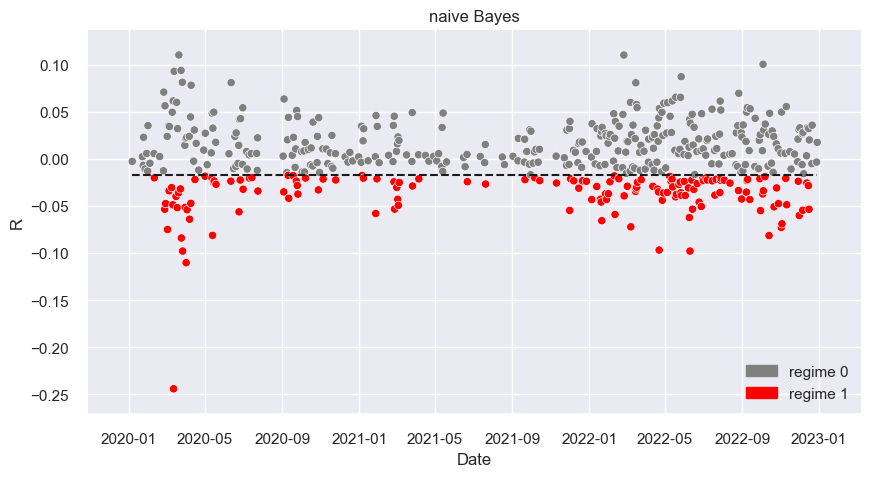

In [71]:
""" Checking linear separability for naive Bayes Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=nb.R['test'], c=np.where(nb.regimes_test==1, 'red','gray'))
plt.hlines(np.max(nb.R['test'][nb.regimes_test==1]),xmin=nb.R['test'].index[0],xmax=nb.R['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('R')
ax.set_xlabel('Date')
ax.set_title('naive Bayes')
None

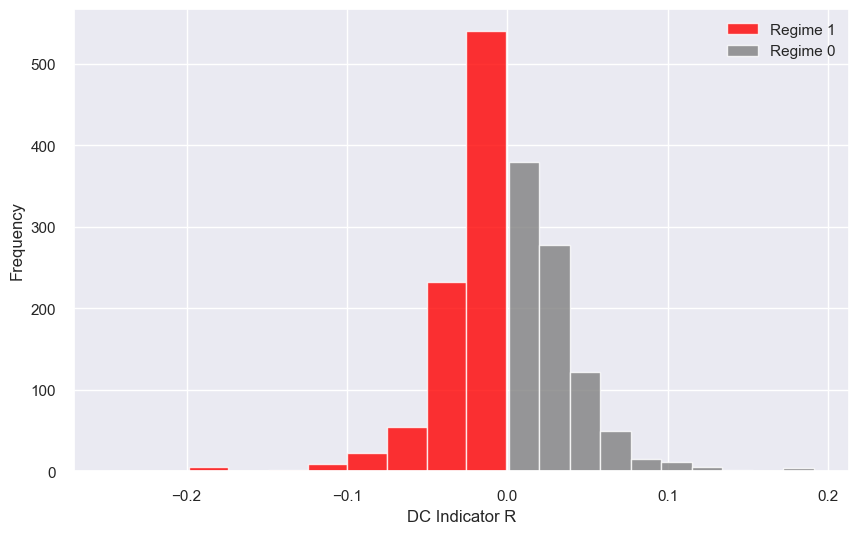

In [72]:
fig,ax = plt.subplots(figsize=(10,6))
nb.R['train'][nb.regimes == 1].plot.hist(ax=ax,alpha=0.8,color='red',label='Regime 1')
nb.R['train'][nb.regimes == 0].plot.hist(ax=ax,alpha=0.8,color='grey', label='Regime 0')
ax.legend()
ax.set_xlabel("DC Indicator R")
plt.show()

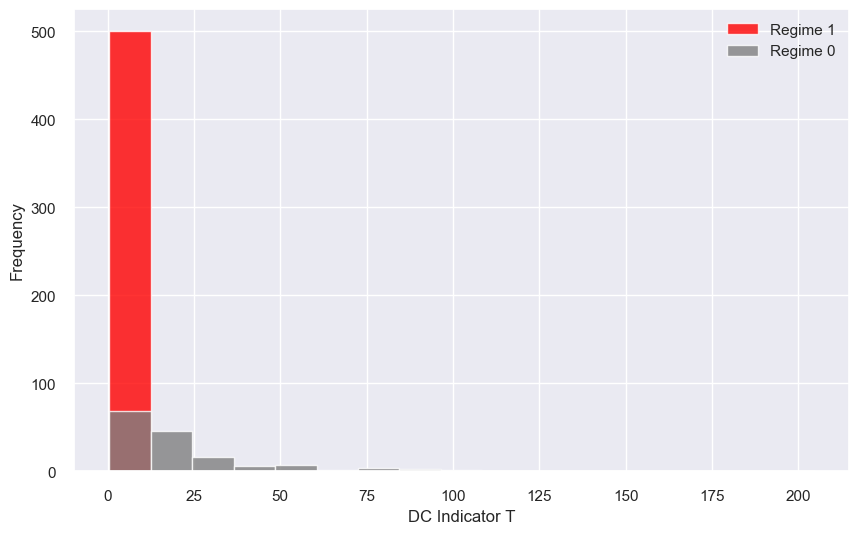

In [80]:
fig,ax = plt.subplots(figsize=(10,6))
lr.T['train'][lr.regimes == 1].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='red',label='Regime 1')
lr.T['train'][lr.regimes == 0].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='gray', label='Regime 0')
ax.legend()
ax.set_xlabel("DC Indicator T")
plt.show()